# Introduction
Utilisation d'un Mask-RCNN pré-entrainé développé par Waleed Abdulla sous une licence du MIT. On étend le model sur les données des hélicoptères pour détecter les codes d'enregistrement en utilisant du transfert learning.

Copyright (c) 2017 Matterport, Inc.

https://github.com/ahmedfgad/Mask-RCNN-TF2


# Chargement des librairies

## Load path to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AMSE/Hackaton Airbus

/content/drive/MyDrive/AMSE/Hackaton Airbus


In [ ]:
#import shutil

#source_folder = r"/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/train/annots"
#destination_folder = r"/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/valid/annots"
#shutil.copytree(source_folder, destination_folder)

## Load requierments library

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
! pip install imgaug

# Transfert learning : entrainement des poids

(Partie qui peut être sauté si les poids ont déjà été entrainés)

## Utilisation de la Dataset Class qui permet de charger le train et validation set

In [ ]:
import os
import cv2
import xml.etree
from numpy import zeros, asarray
import pandas as pd
import numpy as np
import imgaug
from google.colab.patches import cv2_imshow

import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.visualize

Using TensorFlow backend.


In [ ]:
class HelicoDataset(mrcnn.utils.Dataset):

# Chargement des dataset
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "helico")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in os.listdir(images_dir):
            # Remove the .png
            image_id = filename[:-4]
            img_path = images_dir + filename
            # add the .xml to read the corresponding label
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

# Chargement des boites labels
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('helico'))
        return masks, asarray(class_ids, dtype='int32')

    #Fonction pour extraire les coordonnées des boîtes
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

## Importation du train et validation set 

In [ ]:
# Train
train_dataset = HelicoDataset()
train_dataset.load_dataset(dataset_dir='helico/train', is_train=True)
train_dataset.prepare()

# Validation
validation_dataset = HelicoDataset()
validation_dataset.load_dataset(dataset_dir='helico/valid', is_train=False)
validation_dataset.prepare()

## Chargement du model pre-entrainé 

In [ ]:
class HelicoConfig(mrcnn.config.Config):
    NAME = "helico_cfg"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 60

In [ ]:
helico_config = HelicoConfig()

## Extraction des nouveaux poids, construit sur la base du COCO dataset et entrainé avec le données du train set

In [ ]:
# Mise en place de l'architecture du model Mask R-CNN

model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./', 
                             config=helico_config)

model.load_weights(filepath='helico/weights/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=helico_config.LEARNING_RATE, 
            epochs= 5, 
            # Re-entrainement de toutes les couches
            layers='all',
            # Augmentation du dataset
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                    # Rotation de l'image à 25°
                    imgaug.augmenters.Affine(rotate=(-25, 25)),
                    # Floutage des images avec une distribution Gaussienne 
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 1.5)),
                    # Augmentation du contraste
                    imgaug.augmenters.LogContrast(gain=(0.6, 1.4)),
                    # Zoom
                    imgaug.augmenters.Affine(scale=(0.5, 1.5))
                ]
            ))

model_path = 'helico/weights/helico_mask_rcnn_trained.h5'
model.keras_model.save_weights(model_path)


Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_helico_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
re

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
60/60 [==============================] - 123s 2s/step - loss: 1.9133 - val_loss: 1.8480
Epoch 2/5
60/60 [==============================] - 68s 1s/step - loss: 1.1975 - val_loss: 1.2148
Epoch 3/5
60/60 [==============================] - 69s 1s/step - loss: 1.1394 - val_loss: 1.1728
Epoch 4/5
60/60 [==============================] - 69s 1s/step - loss: 1.2326 - val_loss: 1.5319
Epoch 5/5
60/60 [==============================] - 70s 1s/step - loss: 1.1427 - val_loss: 0.7215


In [ ]:
CLASS_NAMES = ['BG','helico_code']

class SimpleConfig(mrcnn.config.Config):
    NAME = "helico_inference"
    # Nombre de GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
	# Nombre de classe = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Test images
Charger les images tests, récupérer leur id et coordonnées avec le meilleur score

## IImportation des images

In [ ]:
import glob
import cv2

In [ ]:
image_test = []
for filename in glob.glob('/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/test/*.jpg'): 
    read=cv2.imread(filename)
    image_test.append(read)

In [ ]:
len(image_test)

374

## Extraction des ID_Photo

In [ ]:
id_test =[]
for filename in glob.glob('/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/test/*.jpg'):
    name = (os.path.splitext(filename)[0].split("/test/",1)[1])
    #name2 = name.split("_",1)[0]
    #name3 = "ID_"+name
    id_test.append(name)

In [ ]:
print(len(id_test))
id_test[130]

374


'ID15987_Mi28_RF-13654_6'

## Extraction des racines xml

In [ ]:
xml_list = []
for k in range(len(id_test)):
  xml = "/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/train/annots/"+id_test[k]+".xml"
  xml_list.append(xml)


In [ ]:
print(len(xml_list))
xml_list[130]

374


'/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/train/annots/ID15987_Mi28_RF-13654_6.xml'

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
root_list = []
for k in range(len(xml_list)):
    root = ET.parse(xml_list[k]).getroot()
    root_list.append(root)

In [ ]:
print(len(root_list))
root_list[130]

374


<Element 'annotation' at 0x7f87a28978f0>

## Compter le nombre de "vrai" label dans chaque fichier

In [ ]:
nb_object=[]
for k in range(len(root_list)):
    root = root_list[k]
    tag=[]
    for child in root:
        tag.append(child.tag)
    nb_object.append(tag.count('object'))

In [ ]:
set(nb_object)

{1, 2, 3, 4, 5, 11}

In [ ]:
test = pd.DataFrame({
    'Photo_ID': id_test,
    'img': image_test,
    'object': nb_object,
    'root' : root_list
})
test.head()

,Photo_ID,img,object,root
0,ID10316_Mi8_B-7803_1,"[[[136, 123, 115], [128, 119, 109], [128, 122,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
1,ID10019_Mi2_RF-00522_9,"[[[210, 208, 207], [210, 208, 207], [209, 207,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
2,ID10108_Mi2_UR-MSM_1,"[[[165, 144, 123], [165, 142, 126], [164, 141,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
3,ID10188_Mi17_XT_BF-9001_3,"[[[55, 73, 90], [54, 72, 89], [53, 71, 88], [5...",2,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
4,ID10023_W3_EC-KSQ_1,"[[[205, 193, 175], [205, 192, 176], [205, 192,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."


In [ ]:
test_filter = test[(test['object']==2)|(test['object']==3)|(test['object']==4)|(test['object']==5)|(test['object']==11)]
test_filter.shape

(61, 4)

### Enlever les images avec plus de 1 labels

In [ ]:
print('Il y a ', round((test_filter.shape[0]/test.shape[0])*100,2),"% des images qui ont des labels multiples (entre 2 et 11)")

Il y a  16.31 % des images qui ont des labels multiples (entre 2 et 11)


In [ ]:
test_01 = test[test['object']==1]
test_01 = test_01.reset_index(drop=True)

In [ ]:
print(test_01.shape)
test_01.head()

(313, 4)


,Photo_ID,img,object,root
0,ID10316_Mi8_B-7803_1,"[[[136, 123, 115], [128, 119, 109], [128, 122,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
1,ID10019_Mi2_RF-00522_9,"[[[210, 208, 207], [210, 208, 207], [209, 207,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
2,ID10108_Mi2_UR-MSM_1,"[[[165, 144, 123], [165, 142, 126], [164, 141,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
3,ID10023_W3_EC-KSQ_1,"[[[205, 193, 175], [205, 192, 176], [205, 192,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."
4,ID10190_Mi8_OB-2078-P_1,"[[[223, 214, 204], [221, 215, 204], [220, 214,...",1,"[[], [], [], [[]], [[], [], []], [], [[], [], ..."


In [ ]:
root_list_ = test_01['root'].tolist()

## Extraires les "vrais" coordonnées des images

In [ ]:
axis_list=[]
name_list = []
size_list = []

for k in range(0,test_01.shape[0]):
    root = root_list_[k]
    
    for ann in root.iter('annotation'):
      name = ann.find('filename').text
      name1 = name[:-4]
      name_list.append(name1)

    for obj in root.iter('object'):
      # Find the box target
      xmlbox = obj.find('bndbox')  
      # Take out the four vertex coordinates of the box target
      x0 = int(xmlbox.find('xmin').text)  
      y0 = int(xmlbox.find('ymin').text)
      x1 = int(xmlbox.find('xmax').text)
      y1 = int(xmlbox.find('ymax').text)
      axis_list.append([x0,y0,x1,y1])

    for lon in root.iter('size'):
      width = int(lon.find('width').text)
      height = int(lon.find('height').text)
      size_list.append([width, height])

In [ ]:
print(len(axis_list))
print(len(name_list))

313
313


In [ ]:
coordinates = pd.DataFrame ({
    'Photo_ID' : name_list,
    'coordinates' : axis_list,
    'size' : size_list
})
coordinates.head()

,Photo_ID,coordinates,size
0,ID10316_Mi8_B-7803_1,"[688, 163, 735, 208]","[1024, 778]"
1,ID10019_Mi2_RF-00522_9,"[406, 262, 558, 297]","[1200, 785]"
2,ID10108_Mi2_UR-MSM_1,"[391, 331, 485, 355]","[1000, 695]"
3,ID10023_W3_EC-KSQ_1,"[395, 387, 514, 436]","[1200, 829]"
4,ID10190_Mi8_OB-2078-P_1,"[634, 309, 738, 333]","[1024, 683]"


## Dataframe intial avec les vrais coordonnées

In [ ]:
test_02 = pd.merge(test_01,coordinates, on="Photo_ID")
test_02 = test_02.drop('root',axis=1)
print(test_02.shape)
test_02.head()

(313, 5)


,Photo_ID,img,object,coordinates,size
0,ID10316_Mi8_B-7803_1,"[[[136, 123, 115], [128, 119, 109], [128, 122,...",1,"[688, 163, 735, 208]","[1024, 778]"
1,ID10019_Mi2_RF-00522_9,"[[[210, 208, 207], [210, 208, 207], [209, 207,...",1,"[406, 262, 558, 297]","[1200, 785]"
2,ID10108_Mi2_UR-MSM_1,"[[[165, 144, 123], [165, 142, 126], [164, 141,...",1,"[391, 331, 485, 355]","[1000, 695]"
3,ID10023_W3_EC-KSQ_1,"[[[205, 193, 175], [205, 192, 176], [205, 192,...",1,"[395, 387, 514, 436]","[1200, 829]"
4,ID10190_Mi8_OB-2078-P_1,"[[[223, 214, 204], [221, 215, 204], [220, 214,...",1,"[634, 309, 738, 333]","[1024, 683]"


# Charger le modèle avec les nouveaux poids

In [ ]:
# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath="helico/weights/helico_mask_rcnn_trained.h5", 
                   by_name=True)

## Exemple on one observation

In [ ]:
# load the input image, convert it from BGR to RGB channel
#ID_5632465_96620_1132407556

image = cv2.imread("helico/test/ID_6288276_15560_1214631265.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

# Utiliser le modèle pour extraires les coordonnées prédits

## Extraction

In [ ]:
photo_id=[]
coordinate_opt =[]
score_opt = []
for k, row in test_02.iterrows() :
    im2 = row['img']

    #gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    #thresh1 = cv2.adaptiveThreshold(gray,
    #                                255,
    #                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                cv2.THRESH_BINARY_INV,
    #                                21, 11)
    image = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
    r = model.detect([image])
    r = r[0]

    scores_list=[]
    coord_list = []
    if len(r['scores']) != 0:
      for k in range(len(r['scores'])):
          scores_list.append(r['scores'][k])
          coord_list.append(r['rois'][k])
    if len(r['scores']) == 0:
      scores_list.append(0)
      coord_list.append([0,0,0,0])
      
    accuracy = pd.DataFrame({
      'coordinates' : coord_list,
      'scores' : scores_list})
    optimal = accuracy[accuracy.scores == accuracy.scores.max()]
    pred_coordinates = optimal['coordinates'][0]
    order = [1, 0, 3, 2]
    pred_coordinates = [pred_coordinates[i] for i in order]

    coordinate_opt.append(pred_coordinates)
    score_opt.append(optimal['scores'][0])

    id_ = row['Photo_ID']
    photo_id.append(id_)   


In [ ]:
print(len(coordinate_opt))
print(len(photo_id))


313
313


## Dataframe avec les "vrais" et prédits coordonnées

In [ ]:
coordinate = pd.DataFrame({
    'Photo_ID' : photo_id,
    'predicted_coordinates' : coordinate_opt,
    'score' : score_opt 
})
test_03 = pd.merge(test_02, coordinate, on="Photo_ID")
print(test_03.shape)
test_03.head()

(313, 7)


,Photo_ID,img,object,coordinates,size,predicted_coordinates,score
0,ID10316_Mi8_B-7803_1,"[[[136, 123, 115], [128, 119, 109], [128, 122,...",1,"[688, 163, 735, 208]","[1024, 778]","[513, 243, 551, 294]",0.951637
1,ID10019_Mi2_RF-00522_9,"[[[210, 208, 207], [210, 208, 207], [209, 207,...",1,"[406, 262, 558, 297]","[1200, 785]","[439, 573, 507, 599]",0.975610
2,ID10108_Mi2_UR-MSM_1,"[[[165, 144, 123], [165, 142, 126], [164, 141,...",1,"[391, 331, 485, 355]","[1000, 695]","[394, 331, 488, 355]",0.966591
3,ID10023_W3_EC-KSQ_1,"[[[205, 193, 175], [205, 192, 176], [205, 192,...",1,"[395, 387, 514, 436]","[1200, 829]","[810, 548, 883, 579]",0.973593
4,ID10190_Mi8_OB-2078-P_1,"[[[223, 214, 204], [221, 215, 204], [220, 214,...",1,"[634, 309, 738, 333]","[1024, 683]","[646, 306, 739, 330]",0.977795


### Regarder combien d'observation n'ont pas de prédiction

In [ ]:
filtre_null = test_03[test_03['score']==0]
filtre_null

,Photo_ID,img,object,coordinates,size,predicted_coordinates,score
126,ID2552_Mi8_DDR_751_1,"[[[222, 212, 212], [219, 209, 209], [216, 206,...",1,"[304, 286, 355, 327]","[1024, 707]","[0, 0, 0, 0]",0.0
148,ID463_Mi17_OK_9799_1,"[[[56, 64, 64], [50, 58, 58], [53, 63, 63], [5...",1,"[387, 717, 471, 856]","[1600, 1207]","[0, 0, 0, 0]",0.0
219,ID7552_Mi17_G_ZB698_5,"[[[225, 216, 207], [224, 214, 207], [220, 211,...",1,"[285, 293, 319, 309]","[1024, 759]","[0, 0, 0, 0]",0.0
234,ID7824_Mi17_T9_A-2605_2,"[[[211, 144, 95], [210, 143, 94], [210, 143, 9...",1,"[746, 361, 801, 395]","[1024, 708]","[0, 0, 0, 0]",0.0
252,ID9195_Mi8_SP_633_5,"[[[242, 244, 245], [241, 243, 244], [244, 246,...",1,"[250, 328, 285, 375]","[1024, 712]","[0, 0, 0, 0]",0.0


In [ ]:
#test_03.to_csv('/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/coordinates_detections.csv',index=False)

### Normaliser les coordonnées pour le calcul des métrics

In [ ]:
coord_norm_pred = []
coord_norm_true = []

for j in range(len(test_03)):
  coord = test_03["predicted_coordinates"][j]
  size = test_03["size"][j]

  xmin = coord[0]/size[0]
  xmax = coord[2]/size[0]
  ymin = coord[1]/size[1]
  ymax = coord[3]/size[1]

  coord_norm_pred.append([xmin,ymin,xmax,ymax])


  coord_true = test_03["coordinates"][j]
  xmin = coord_true[0]/size[0]
  xmax = coord_true[2]/size[0]
  ymin = coord_true[1]/size[1]
  ymax = coord_true[3]/size[1]

  coord_norm_true.append([xmin,ymin,xmax,ymax])

test_03["coord_norm_predict"] = coord_norm_pred
test_03["coord_norm_true"] = coord_norm_true

### Fichiers CSV pour calculer les AP et mAP

In [ ]:
# For predicted values
xmin_list=[]
xmax_list=[]
ymin_list=[]
ymax_list=[]
id_list_ =[]

for k,row in test_03.iterrows() :
  xmin_list.append(row['coord_norm_predict'][0])
  xmax_list.append(row['coord_norm_predict'][1])
  ymin_list.append(row['coord_norm_predict'][2])
  ymax_list.append(row['coord_norm_predict'][3])

  id_list_.append(row['Photo_ID'])

result_detection = pd.DataFrame({
    'ImageID' : id_list_,
    'Label' : id_list_,
    'score' : test_03["score"],
    'XMin' : xmin_list,
    'XMax' : xmax_list,
    'YMin' : ymin_list,
    'YMax' : ymax_list
})

result_detection.head()

,ImageID,Label,score,XMin,XMax,YMin,YMax
0,ID10316_Mi8_B-7803_1,ID10316_Mi8_B-7803_1,0.951637,0.500977,0.312339,0.538086,0.377892
1,ID10019_Mi2_RF-00522_9,ID10019_Mi2_RF-00522_9,0.975610,0.365833,0.729936,0.422500,0.763057
2,ID10108_Mi2_UR-MSM_1,ID10108_Mi2_UR-MSM_1,0.966591,0.394000,0.476259,0.488000,0.510791
3,ID10023_W3_EC-KSQ_1,ID10023_W3_EC-KSQ_1,0.973593,0.675000,0.661037,0.735833,0.698432
4,ID10190_Mi8_OB-2078-P_1,ID10190_Mi8_OB-2078-P_1,0.977795,0.630859,0.448023,0.721680,0.483163


In [ ]:
# For true values
xmin_list=[]
xmax_list=[]
ymin_list=[]
ymax_list=[]
id_list_ =[]

for k,row in test_03.iterrows() :
  xmin_list.append(row['coord_norm_true'][0])
  xmax_list.append(row['coord_norm_true'][1])
  ymin_list.append(row['coord_norm_true'][2])
  ymax_list.append(row['coord_norm_true'][3])

  id_list_.append(row['Photo_ID'])

result_detection_true = pd.DataFrame({
    'ImageID' : id_list_,
    'Label' : id_list_,
    'XMin' : xmin_list,
    'XMax' : xmax_list,
    'YMin' : ymin_list,
    'YMax' : ymax_list
})

result_detection_true.head()

,ImageID,Label,XMin,XMax,YMin,YMax
0,ID10316_Mi8_B-7803_1,ID10316_Mi8_B-7803_1,0.671875,0.209512,0.717773,0.267352
1,ID10019_Mi2_RF-00522_9,ID10019_Mi2_RF-00522_9,0.338333,0.333758,0.465000,0.378344
2,ID10108_Mi2_UR-MSM_1,ID10108_Mi2_UR-MSM_1,0.391000,0.476259,0.485000,0.510791
3,ID10023_W3_EC-KSQ_1,ID10023_W3_EC-KSQ_1,0.329167,0.466828,0.428333,0.525935
4,ID10190_Mi8_OB-2078-P_1,ID10190_Mi8_OB-2078-P_1,0.619141,0.452416,0.720703,0.487555


In [ ]:
result_detection.to_csv('helico/DETcoordinates_detections.csv',index=False)

In [ ]:
result_detection_true.to_csv('helico/ANNOTcoordinates_detections.csv',index=False)

## Formatation de la table de sortie

In [ ]:
xmin_list=[]
xmax_list=[]
ymin_list=[]
ymax_list=[]
id_list_ =[]

for k,row in test_03.iterrows() :
  xmin_list.append(row['coord_norm_predict'][0])
  xmax_list.append(row['coord_norm_predict'][1])
  ymin_list.append(row['coord_norm_predict'][2])
  ymax_list.append(row['coord_norm_predict'][3])

  id_list_.append(row['Photo_ID'])

result_detection = pd.DataFrame({
    'ImageID' : id_list_,
    'XMin' : xmin_list,
    'XMax' : xmax_list,
    'YMin' : ymin_list,
    'YMax' : ymax_list
})

result_detection.head()

,ImageID,XMin,XMax,YMin,YMax
0,ID10316_Mi8_B-7803_1,0.500977,0.312339,0.538086,0.377892
1,ID10019_Mi2_RF-00522_9,0.365833,0.729936,0.422500,0.763057
2,ID10108_Mi2_UR-MSM_1,0.394000,0.476259,0.488000,0.510791
3,ID10023_W3_EC-KSQ_1,0.675000,0.661037,0.735833,0.698432
4,ID10190_Mi8_OB-2078-P_1,0.630859,0.448023,0.721680,0.483163


# Metrics pour évaluer les prédictions

## Visualisation

0.9830629825592041


0.9861220717430115


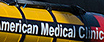

0.9458643794059753


0.9752471446990967


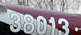

0.9796628355979919


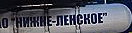

In [ ]:
for k in range(10,15):
  x0,y0,x1,y1 = test_03['predicted_coordinates'][k]
  crop_img = test_03['img'][k][y0:y1,x0:x1]
  #bl,tl,br,tr = test_03['predicted_coordinates'][k]
  #crop_img = test_03['img'][k][bl:br,tl:tr]
  print(test_03['score'][k])
  cv2_imshow(crop_img)

In [ ]:
"""for k in range(0,5):
  img = test_03['img'][k]
  x0a,y0a,x1a,y1a = test_03['coordinates'][k]
  x0b,y0b,x1b,y1b = test_03['predicted_coordinates'][k]
  cv2.rectangle(img, (x0a,y0a),(x1a,y1a),color = (102, 158, 106),thickness= 2)
  cv2.rectangle(img, (x0b,y0b),(x1b,y1b), color= (220, 61, 61),thickness= 2)

  cv2_imshow(img)"""

"for k in range(0,5):\n  img = test_03['img'][k]\n  x0a,y0a,x1a,y1a = test_03['coordinates'][k]\n  x0b,y0b,x1b,y1b = test_03['predicted_coordinates'][k]\n  cv2.rectangle(img, (x0a,y0a),(x1a,y1a),color = (102, 158, 106),thickness= 2)\n  cv2.rectangle(img, (x0b,y0b),(x1b,y1b), color= (220, 61, 61),thickness= 2)\n\n  cv2_imshow(img)"

"for k in range(0,5):\n  img = test_03['img'][k]\n  x0a,y0a,x1a,y1a = test_03['coordinates'][k]\n  x0b,y0b,x1b,y1b = test_03['predicted_coordinates'][k]\n  cv2.rectangle(img, (x0a,y0a),(x1a,y1a),color = (102, 158, 106),thickness= 2)\n  cv2.rectangle(img, (x0b,y0b),(x1b,y1b), color= (220, 61, 61),thickness= 2)\n\n  cv2_imshow(img)"

## Calcul de la métric IoU

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
IoU_list=[]
id_list_ =[]
for k,row in test_03.iterrows() :
  original = row['coordinates']
  predicted = row['predicted_coordinates']
  iou = bb_intersection_over_union(original,predicted)
  IoU_list.append(iou)
  id_list_.append(row['Photo_ID'])

In [ ]:
eval_1 = pd.DataFrame({
    'Photo_ID' : id_list_,
    'IoU' : IoU_list
})
test_04 = pd.merge(test_03, eval_1, on="Photo_ID")
print(test_04.shape)
#test_04.head()

(313, 10)


In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
test_04['IoU'].describe()

count    313.000000
mean       0.494878
std        0.286602
min        0.000000
25%        0.406957
50%        0.603261
75%        0.699172
max        0.959983
Name: IoU, dtype: float64

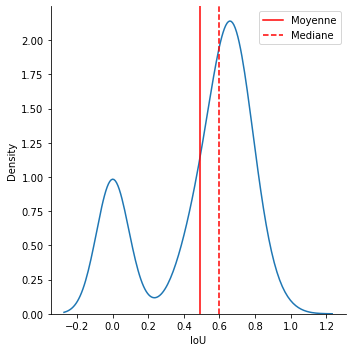

In [ ]:
ax = sns.displot(test_04['IoU'], kind="kde")
plt.axvline(0.49, color='red',label = 'Moyenne')
plt.axvline(0.60, color='red',linestyle='dashed',label='Mediane')
plt.legend(loc="upper right")
plt.show()

In [ ]:
test_04['TP'] = np.where(test_04['IoU']>=0.5, 1, 0)
test_04['TP'].describe()

count    313.000000
mean       0.670927
std        0.470629
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: TP, dtype: float64

## Calcul des métrics AP and mAP

Utilisation de la librairie map-boxes:
https://github.com/ZFTurbo/Mean-Average-Precision-for-Boxes



In [ ]:
!pip install map-boxes

In [ ]:
from map_boxes import mean_average_precision_for_boxes
import pandas as pd

/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /usr/local/lib/python3.7/dist-packages/map_boxes/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
ann = pd.read_csv('/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/ANNOTcoordinates_detections.csv')
det = pd.read_csv('/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/DETcoordinates_detections.csv')

ann = ann[['ImageID', 'Label', 'XMin', 'XMax', 'YMin', 'YMax']].values
det = det[['ImageID', 'Label', 'score', 'XMin', 'XMax', 'YMin', 'YMax']].values

mean_ap, average_precisions = mean_average_precision_for_boxes(ann, det)

Number of files in annotations: 313
Number of files in predictions: 313
Unique classes: 313
Detections length: 313
Annotations length: 313
ID10019_Mi2_RF-00522_9         | 0.000000 |       1
ID10023_W3_EC-KSQ_1            | 1.000000 |       1
ID10079_Mi17_RF-93125_1        | 0.000000 |       1
ID10108_Mi2_UR-MSM_1           | 0.000000 |       1
ID10190_Mi8_OB-2078-P_1        | 0.000000 |       1
ID10210_W3_EC-KSA_2            | 0.000000 |       1
ID10265_Mi17_RA-22312_1        | 1.000000 |       1
ID10316_Mi8_B-7803_1           | 0.000000 |       1
ID10426_Mi17_RA-22980_4        | 0.000000 |       1
ID1043_Mi2_RA-23310_1          | 0.000000 |       1
ID10480_Mi8_RA-24100_7         | 0.000000 |       1
ID10497_Mi2_RF-00225_1         | 0.000000 |       1
ID10526_Mi8_RA-22691_4         | 1.000000 |       1
ID10565_Mi17_SP_6104_2         | 0.000000 |       1
ID10568_Mi17_SP_6104_5         | 1.000000 |       1
ID10571_Mi17_SP_6104_8         | 1.000000 |       1
ID10643_Mi17_RA-25129_4      

In [ ]:
AP = pd.DataFrame(average_precisions)
AP = AP.T
AP = AP.rename(columns={0: "AP"})
AP = AP.drop(1,axis=1)
AP['mAP'] = AP['AP']
AP['Photo_ID'] = AP.index
AP.head()

,AP,mAP,Photo_ID
ID10019_Mi2_RF-00522_9,0.0,0.0,ID10019_Mi2_RF-00522_9
ID10023_W3_EC-KSQ_1,1.0,1.0,ID10023_W3_EC-KSQ_1
ID10079_Mi17_RF-93125_1,0.0,0.0,ID10079_Mi17_RF-93125_1
ID10108_Mi2_UR-MSM_1,0.0,0.0,ID10108_Mi2_UR-MSM_1
ID10190_Mi8_OB-2078-P_1,0.0,0.0,ID10190_Mi8_OB-2078-P_1


In [ ]:
cols = list(AP.columns.values)
print(cols)
AP = AP[['Photo_ID', 'AP', 'mAP']]
AP.head()

['AP', 'mAP', 'Photo_ID']


,Photo_ID,AP,mAP
ID10019_Mi2_RF-00522_9,ID10019_Mi2_RF-00522_9,0.0,0.0
ID10023_W3_EC-KSQ_1,ID10023_W3_EC-KSQ_1,1.0,1.0
ID10079_Mi17_RF-93125_1,ID10079_Mi17_RF-93125_1,0.0,0.0
ID10108_Mi2_UR-MSM_1,ID10108_Mi2_UR-MSM_1,0.0,0.0
ID10190_Mi8_OB-2078-P_1,ID10190_Mi8_OB-2078-P_1,0.0,0.0


In [ ]:
AP = pd.merge(AP, eval_1, on="Photo_ID")
print(AP.shape)
AP.head()

(313, 4)


,Photo_ID,AP,mAP,IoU
0,ID10019_Mi2_RF-00522_9,0.0,0.0,0.000000
1,ID10023_W3_EC-KSQ_1,1.0,1.0,0.727201
2,ID10079_Mi17_RF-93125_1,0.0,0.0,0.035955
3,ID10108_Mi2_UR-MSM_1,0.0,0.0,0.771574
4,ID10190_Mi8_OB-2078-P_1,0.0,0.0,0.774302


In [ ]:
! pip install xlsxwriter

     |████████████████████████████████| 149 kB 4.1 MB/s 


# Travail sur les données JETSON

In [ ]:
registration_00 = pd.read_csv("/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/registration_data.csv")
registration_00 = registration_00.drop('Unnamed: 0',axis=1)
registration_00 = registration_00[registration_00['Source']=='Jetson']
print(registration_00.shape)
registration_00.head()

(780, 3)


,Photo_ID,Registration,Source
472,ID_10348277,VH-ZZM,Jetson
473,ID_10347638,F-GKMB,Jetson
474,ID_10347256,VH-ZZM,Jetson
475,ID_10346634,ZK-IWE,Jetson
476,ID_10329478,C-FIZA,Jetson


In [ ]:
import os

files = []
img =[]

path_train = '/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/train/images/'

for i in os.listdir(path_train):
    if os.path.isfile(os.path.join(path_train,i)) and 'ID_' in i:
        files.append(i)
        img.append(cv2.imread(path_train+i))

path_test = '/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/test/'

for i in os.listdir(path_test):
    if os.path.isfile(os.path.join(path_test,i)) and 'ID_' in i:
        files.append(i)
        img.append(cv2.imread(path_test+i))

path_validation = '/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/valid/images/'

for i in os.listdir(path_validation):
    if os.path.isfile(os.path.join(path_validation,i)) and 'ID_' in i:
        files.append(i)
        img.append(cv2.imread(path_validation+i))


In [ ]:
jetson = pd.DataFrame({
    'image_ID' : files,
    'img' : img
})
print(jetson.shape)
jetson.head()

(680, 2)


,image_ID,img
0,ID_9994178_26729_1608745386.jpg,"[[[205, 238, 253], [206, 239, 255], [206, 239,..."
1,ID_9919731_62316_1604099596.jpg,"[[[224, 200, 194], [224, 200, 194], [225, 201,..."
2,ID_9972804_59390_1607826528.jpg,"[[[215, 162, 105], [215, 163, 103], [213, 161,..."
3,ID_9944507_66642_1606359235.jpg,"[[[255, 161, 85], [255, 161, 85], [255, 162, 8..."
4,ID_9852567_22511_1599381222.jpg,"[[[207, 184, 169], [207, 184, 169], [206, 183,..."


### Extraction du Photo_ID

In [ ]:
image_id = jetson['image_ID'].tolist()
image_id[0]

'ID_9994178_26729_1608745386.jpg'

In [ ]:
df_list =[]
for k in range(len(image_id)):
    name = image_id[k][:-4]
    if name.startswith('ID') == True :
      name1 = name.split("ID",1)[1]
      name2 = name1.split("_",1)[0]
      name3 = "ID"+name2
    if name.startswith('ID_') == True :
      name1 = name.split("ID_",1)[1]
      name2 = name1.split("_",1)[0]
      name3 = "ID_"+name2

    df_list.append(name3)
print(len(df_list))
print(df_list[0])

680
ID_9994178


In [ ]:
jetson_01 = pd.DataFrame({
    'Photo_ID' : df_list,
    'img' : jetson['img']
})
jetson_01.head()

,Photo_ID,img
0,ID_9994178,"[[[205, 238, 253], [206, 239, 255], [206, 239,..."
1,ID_9919731,"[[[224, 200, 194], [224, 200, 194], [225, 201,..."
2,ID_9972804,"[[[215, 162, 105], [215, 163, 103], [213, 161,..."
3,ID_9944507,"[[[255, 161, 85], [255, 161, 85], [255, 162, 8..."
4,ID_9852567,"[[[207, 184, 169], [207, 184, 169], [206, 183,..."


In [ ]:
photo_id=[]
coordinate_opt =[]
score_opt = []

for k, row in jetson_01.iterrows() :
    im2 = row['img']
    image = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
    r = model.detect([image])
    r = r[0]

    scores_list=[]
    coord_list = []
    if len(r['scores']) != 0:
      for k in range(len(r['scores'])):
          scores_list.append(r['scores'][k])
          coord_list.append(r['rois'][k])
    if len(r['scores']) == 0:
      scores_list.append(0)
      coord_list.append([0,0,0,0])
      
    accuracy = pd.DataFrame({
      'coordinates' : coord_list,
      'scores' : scores_list})
    optimal = accuracy[accuracy.scores == accuracy.scores.max()]
    pred_coordinates = optimal['coordinates'][0]
    order = [1, 0, 3, 2]
    pred_coordinates = [pred_coordinates[i] for i in order]

    coordinate_opt.append(pred_coordinates)
    score_opt.append(optimal['scores'][0])

    id_ = row['Photo_ID']
    photo_id.append(id_)   


In [ ]:
coordinate_ = pd.DataFrame({
    'Photo_ID' : photo_id,
    'predicted_coordinates' : coordinate_opt,
    'score' : score_opt 
})
jetson_02 = pd.merge(jetson_01, coordinate_, on="Photo_ID")
print(jetson_02.shape)
jetson_02.head()

(680, 4)


,Photo_ID,img,predicted_coordinates,score
0,ID_9994178,"[[[205, 238, 253], [206, 239, 255], [206, 239,...","[663, 335, 747, 368]",0.991956
1,ID_9919731,"[[[224, 200, 194], [224, 200, 194], [225, 201,...","[1120, 484, 1254, 524]",0.974369
2,ID_9972804,"[[[215, 162, 105], [215, 163, 103], [213, 161,...","[877, 384, 960, 412]",0.949703
3,ID_9944507,"[[[255, 161, 85], [255, 161, 85], [255, 162, 8...","[508, 310, 680, 348]",0.974494
4,ID_9852567,"[[[207, 184, 169], [207, 184, 169], [206, 183,...","[681, 407, 748, 450]",0.969679


In [ ]:
jetson_03 = pd.merge(jetson_02, registration_00, on="Photo_ID")
print(jetson_03.shape)
jetson_03.head()

(680, 6)


,Photo_ID,img,predicted_coordinates,score,Registration,Source
0,ID_9994178,"[[[205, 238, 253], [206, 239, 255], [206, 239,...","[663, 335, 747, 368]",0.991956,9H-MPR,Jetson
1,ID_9919731,"[[[224, 200, 194], [224, 200, 194], [225, 201,...","[1120, 484, 1254, 524]",0.974369,9H-MPR,Jetson
2,ID_9972804,"[[[215, 162, 105], [215, 163, 103], [213, 161,...","[877, 384, 960, 412]",0.949703,VH-JRI,Jetson
3,ID_9944507,"[[[255, 161, 85], [255, 161, 85], [255, 162, 8...","[508, 310, 680, 348]",0.974494,N42SL,Jetson
4,ID_9852567,"[[[207, 184, 169], [207, 184, 169], [206, 183,...","[681, 407, 748, 450]",0.969679,F-GJRP,Jetson


In [109]:
#jetson_03.to_pickle("Jetson2.pkl")

## Utilisation de Pytesseract pour lire du texte

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pytesseract.pytesseract.tesseract_cmd = r'yourpath/tesseract.exe'

In [ ]:
df = pd.read_pickle("Jetson2.pkl")

label = []

for i in range(len(df)):
    
    x0,y0,x1,y1 = df.predicted_coordinates[i]
    label.append(df.img[i][y0:y1,x0:x1])
    
df["label"] = label
df = df[['Photo_ID', 'Source','img', 'predicted_coordinates', 'label', 'Registration']]

remove_list = []

for i in range(len(df)):
    
    val = df.predicted_coordinates[i]
    if val == [0,0,0,0]:
        
        remove_list.append(i)
        
df = df.drop(remove_list, axis = 0)

df = df.reset_index()

df.head()

In [ ]:
%%time

recognized_text = []

sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("FSRCNN-small_x2.pb")
sr.setModel("fsrcnn", 2)

for i in range(len(df)):
    
    img_fst = df.label[i]
    img = sr.upsample(img_fst)
    code = df.Registration[i]
    """plt.imshow(img)
    plt.show()
    print("Code à trouver : " + code)"""
    
    guess = pytesseract.image_to_string(img, config = "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6")
    """print("Guess de pytesseract : " + guess)"""
    
    try:
        
        if guess[0] == "N":

            recognized_text.append(guess)

        else:
            
            guess = pytesseract.image_to_string(img, config = "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ- --psm 6")
            """print("Guess de pytesseract pour code sans N : " + guess)"""
            recognized_text.append(guess)
            
        
            
    except:
    
        recognized_text.append(guess)
        
    '''print("="*50)'''

In [ ]:
recognized_text = list(map(lambda t: t.strip(), recognized_text))
df['recognized_text'] = recognized_text
df['guesses'] = (df.Registration == df.recognized_text).tolist()
print("pourcentage de réussite : " + str((df.guesses.value_counts()[1]/len(df))*100))

In [ ]:
df.head()

In [ ]:
registration_number_reading = pd.read_csv('/content/drive/MyDrive/Mag3/Airbus/Hackaton Airbus/helico/final.csv', sep = ",")
registration_number_reading = registration_number_reading.drop(columns='Unnamed: 0', axis=1)

In [ ]:
# Create a Pandas Excel writer
writer = pd.ExcelWriter('/content/drive/MyDrive/AMSE/Hackaton Airbus/helico/livrable_text_detection.xlsx', engine='xlsxwriter')

# Write first sheet
result_detection.to_excel(writer, sheet_name='result_detection', index=False)
# Write second sheet
AP.to_excel(writer, sheet_name='result_detection_ap_map', index=False)
# Write third sheet
registration_number_reading.to_excel(sheet_name='registration_number_reading', index=False)
# Save
writer.save()

## Research about Pytesseract

### Upscalling : FSRCNN X2
https://towardsdatascience.com/deep-learning-based-super-resolution-with-opencv-4fd736678066

In [ ]:
upscale_guesses = []

sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("FSRCNN-small_x2.pb")
sr.setModel("fsrcnn", 2)

for i in range(len(df)):
    
    plt.imshow(df.label[i])
    plt.show()
    print(pytesseract.image_to_string(df.label[i], config = "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ- --psm 6"))
    
    result = sr.upsample(df.label[i])
    plt.imshow(result)
    plt.show()
    guess = pytesseract.image_to_string(result, config = "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ- --psm 6")
    print(guess)
    
    upscale_guesses.append(guess)
    
    print("="*50)

In [ ]:
upscale_guesses = list(map(lambda t: t.strip(), upscale_guesses))
df['upscaled'] = upscale_guesses
df['guesses2'] = (df.Registration == df.upscaled).tolist()
print("pourcentage de réussite : " + str((df.guesses2.value_counts()[1]/64)*100))

In [ ]:
rd = []

for i in range(len(df)):
    
    image_fst = df.label[i]
    #image = rotateImage(image, -8)
    image = sr.upsample(image_fst)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.invert(gray)
    thresh = cv2.threshold(image,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts, _ = contours.sort_contours(cnts, method="left-to-right")

    ROI_number = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if area > 10:
            x,y,w,h = cv2.boundingRect(c)
            ROI = 255 - image[y:y+h, x:x+w]
            cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 1)
            ROI_number += 1
            
    plt.imshow(image)
    plt.show()
    print(pytesseract.image_to_string(image, config = "--psm 6"))
    rd.append(pytesseract.image_to_string(image, config = "--psm 6"))
    print(i)

In [ ]:
rd = list(map(lambda t: t.strip(), rd))
df['rd'] = rd
df['guesses3'] = (df.Registration == df.rd).tolist()
print("pourcentage de réussite : " + str((df.guesses3.value_counts()[1]/64)*100))

### Rotate image

In [ ]:
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [ ]:
test = rotateImage(df.label[0], -6)
plt.imshow(test)

In [ ]:
image_fst = rotateImage(df.label[8], 10)
image = sr.upsample(image_fst)
plt.imshow(image)
plt.show()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
print(pytesseract.image_to_string(gray, config = "--psm 6"))

In [ ]:
img = rotateImage(df.label[4], 0)
plt.imshow(img)
print(pytesseract.image_to_string(img, config = "--psm 6"))

In [ ]:
result = automatic_brightness_and_contrast(result)
result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
ret, result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
import numpy as np
import imutils

# load the image from disk
image = df.label[0]
result = sr.upsample(image)
'''# loop over the rotation angles
for angle in np.arange(0, 360, 15):
    rotated = imutils.rotate(image, angle)
    plt.imshow(rotated)
    plt.show()'''
# loop over the rotation angles again, this time ensuring
# no part of the image is cut off
for angle in np.arange(0, 360, 15):
    rotated = imutils.rotate_bound(result, angle)
    plt.imshow(rotated)
    plt.show()
    print(pytesseract.image_to_string(rotated, config='8'))

### Brightness

In [ ]:
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result